In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out).reshape(V.shape[0], V.shape[1]) #(batch*50000,1)
        
        return lin_out



In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/V_na_true_0.1noise1_0.2ms.npy").reshape(-1,batch_length)
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [6]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = torch.mean((S_out - batch_S) ** 2)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = torch.mean((S_test - test_S_out) ** 2)
        test_var_exp = explained_variance_score(S_test.flatten().cpu().detach().numpy(),
                                                test_S_out.flatten().cpu().detach().numpy())
        
        score_list.append(test_loss.item())
        print(i, test_loss.item(), test_var_exp)

<ipython-input-6-5c73ecaa3ca6>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 9.847151756286621 0.0013734102249145508
49 9.664799690246582 0.018131017684936523
99 9.545069694519043 0.030266642570495605
149 9.278402328491211 0.05742311477661133
199 9.17901611328125 0.06754112243652344
249 9.08862018585205 0.07707816362380981
299 9.049372673034668 0.08068019151687622
349 8.93808364868164 0.09194290637969971
399 8.829941749572754 0.10291820764541626
449 8.86257553100586 0.0997205376625061
499 8.73419189453125 0.11265027523040771
549 8.690192222595215 0.1172524094581604
599 8.608146667480469 0.12549865245819092
649 8.654165267944336 0.12078636884689331
699 8.601836204528809 0.12611961364746094
749 8.568281173706055 0.1296972632408142
799 8.419174194335938 0.1446858048439026
849 8.556171417236328 0.13072925806045532
899 8.426946640014648 0.14385640621185303
949 8.682710647583008 0.11801153421401978
999 8.310236930847168 0.15577703714370728
1049 8.440320014953613 0.1425173282623291
1099 8.279901504516602 0.15902727842330933
1149 8.322112083435059 0.15450817346572876

KeyboardInterrupt: 

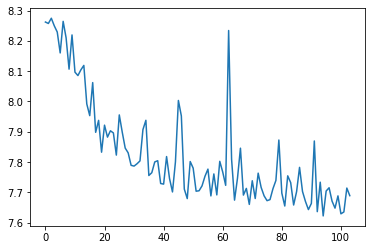

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(33.5246, device='cuda:0', grad_fn=<MaxBackward1>)


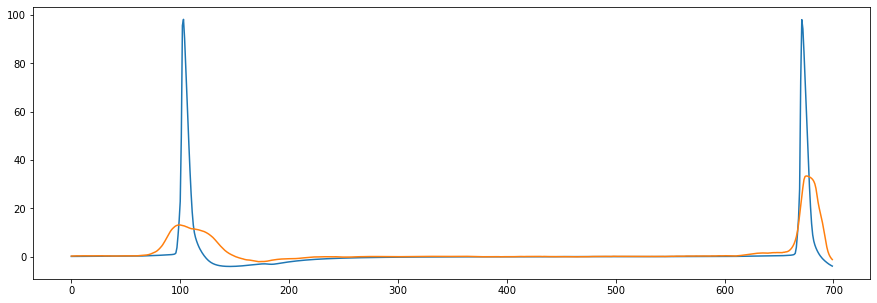

In [7]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[23000:27000][800:1500])
plt.plot(test_S_out[0].cpu().detach().numpy()[23000:27000][800:1500])
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

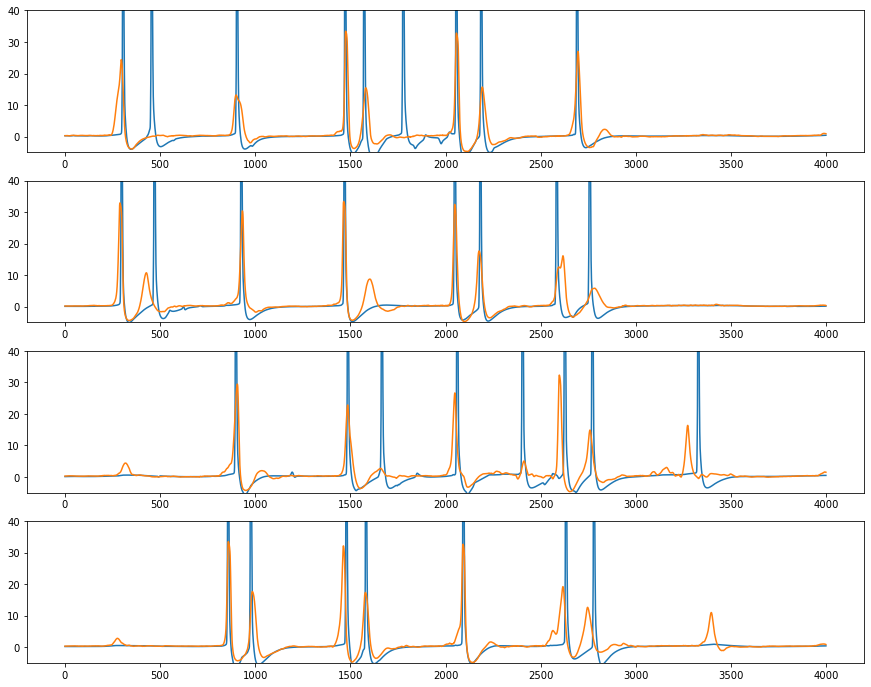

In [8]:
fig, axs = plt.subplots(nrows=4, figsize=(15,12))
for i in range(4):
    axs[i].plot(S_test[i].cpu().detach().numpy()[23000:27000])
    axs[i].plot(test_S_out[i].cpu().detach().numpy()[23000:27000])
    axs[i].set_ylim(-5,40)

In [9]:
test_S_out = test_S_out.cpu().detach().numpy()
test_S_out_next = np.zeros_like(test_S_out)
test_S_out_next[:,:-1] = test_S_out[:,1:]
test_S_out_thresh = np.zeros_like(test_S_out)

thresh = 15

for i in range(test_S_out.shape[0]):
    idx = np.where((test_S_out[i] < thresh) & (test_S_out_next[i] >= thresh))[0]
    test_S_out_thresh[i][idx] = 1

In [10]:
print(np.sum(test_S_out_thresh))

137.0


In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/gru_l20_h40_0.2ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/gru_l20_h40_0.2ms_test.npy", test_S_out.cpu().detach().numpy())

In [11]:
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_V.npy", test_S_out)
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_S.npy", test_S_out_thresh)